# Predicting the number of bikes rented per hour

In this project, we use a few simple machine-learning models (linear regression, decision tree, and random forest) to predict te number of bikes rented by the hour in Washington, D.C.. 
Like many other American cities, Washington, D.C. has a communal bike-renting service. 
Bikes can be rented for eiteher one hour or one day. 

One important problem for cities setting or and maintaning similar services is to estimate how many bicycles are needed and where, to ensure the number of bikes on offer is high enough to cover the residents' needs while avoiding the extra costs and space obstruction of keeping more bikes than necessary. 
We here deal with the first question, and aim at predicting the number of bikes rented per hour. 

## The Dataset

*(Description to be written)*

We first import the packages we will need: 

In [1]:
# Pandas to work with the dataset
import pandas as pd

# Pyplot for plots
import matplotlib.pyplot as plt

Load the dataset and print the first few rows: 

In [2]:
bike_rentals = pd.read_csv('../Data/Bike-Sharing-Dataset/hour.csv')
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Let us see whether there are missing values: 

In [3]:
bike_rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


It seems there is no missing value. 

In principle, the `cnt` column, giving the total number of rentals, should be the sum of the `casual` and `registered` ones. 
Let us check this: 

In [4]:
(bike_rentals['cnt'] == bike_rentals['casual'] + bike_rentals['registered']).value_counts()

True    17379
dtype: int64

This is indeed the case. 
The dataset thus seems consistent in this regard. 

Our target variable will be the `cst` column, giving the total number of rentals for each hour. 
Let us plot a histogram to get a glimpse of its distribution: 

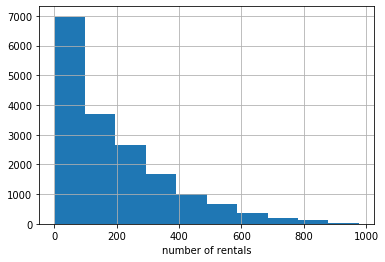

In [5]:
bike_rentals['cnt'].hist()
plt.xlabel('number of rentals')
plt.show()

The distribution seems to be monotonically decreasing, with numbers smaller than 100 for nearly half of the rows. 

Let us now see how the other numeric coluns are correlated with `cnt`: 

In [6]:
bike_rentals.corr()['cnt'].sort_values(ascending=False)

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64

The two columns `registered` and `casual` are strongly correlated with `cnt`. 
This is not surprising as the later is the sum of the former two. 
The corelation is significantly stronger for the `registered` column, which indicates that registered users account for most rentals.

The next variables showing strongest correlation with `cnt` are the temperature (`temp`) and felt temperature (`atemp`), closely followed by the hour (`hr`). 
The humidity (`hum`) also has a significant  negative correlation.

We can not use the `registered` and `casual` columns to make predictions as they are part of what we want to predict. 
It thius seems that the most relevent factors to focus on are the temperature, felt temperature, and humidity.

Let us see whether they are correlated to each others:

In [7]:
cols = ['temp', 'atemp', 'hum']
bike_rentals[cols].corr()

,temp,atemp,hum
temp,1.000000,0.987672,-0.069881
atemp,0.987672,1.000000,-0.051918
hum,-0.069881,-0.051918,1.000000


There is a very strong correlation (close to 0.988) between the temperature and felt temperature. 
It may thus be relevent to include only one of these two columns as they contain essenntially the same information.

## Feature engineering

### Time of the day

Let us first divide the day into 4 equal periods: morning from 6:00 to 11:59, afternoon from 12:00 to 17:59, evening from 18:00 to 23:59, and night from 0:00 to 5:59, associated respectively with the labels 1, 2, 3, and 4. 
We wall this column `time_label`.

In [8]:
def label_hour(hr):
    '''
    labels the hour hr with 1 (morning), 2 (afternoon), 3 (evening), or 4 
    (night)
    
    hr: integer between 0 and 23 (included)
    '''
    if hr < 6:
        return 4
    if hr < 12:
        return 1
    if hr < 18:
        return 2
    return 3

bike_rentals['time_label'] = bike_rentals['hr'].apply(label_hour)
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


### Dropping ununcessary columns

The column `instant` serves an an index, and does not contain any actual information. 
We will also not make use of the `dteday` column.
Let us drop them:

In [9]:
bike_rentals = bike_rentals.drop(['instant', 'dteday'], axis=1)
bike_rentals.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16,4
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40,4
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32,4
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13,4
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1,4


## Separation into training and validation sets

We now divide the dataset into a training set `train` with about 80% of the data and a validation set `test` with the remaining data. 
The performance of the models will be estimated using the mean squared error. 

In [28]:
# we set a random state to make the results reproducible
train = bike_rentals.sample(frac = 0.8, random_state = 25)
test = bike_rentals[~bike_rentals.index.isin(train.index)]

display(train.head())
display(test.head())

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
3555,2,0,6,1,0,4,1,1,0.72,0.6515,0.38,0.1045,3,12,15,4
16834,4,1,12,5,0,0,0,2,0.40,0.4091,0.87,0.1045,0,8,8,4
6971,4,0,10,2,0,0,0,1,0.34,0.3485,0.87,0.0896,10,40,50,4
5165,3,0,8,3,0,1,1,1,0.66,0.5909,0.89,0.0000,1,0,1,4
8913,1,1,1,6,0,4,1,3,0.36,0.3485,0.93,0.1343,1,88,89,1


,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,time_label
8,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,1,7,8,1
14,1,0,1,14,0,6,0,2,0.46,0.4545,0.72,0.2836,35,71,106,2
17,1,0,1,17,0,6,0,2,0.44,0.4394,0.82,0.2836,15,52,67,2
23,1,0,1,23,0,6,0,2,0.46,0.4545,0.88,0.2985,15,24,39,3
25,1,0,1,1,0,0,0,2,0.44,0.4394,0.94,0.2537,1,16,17,4
